In [ ]:
import sys
sys.path.append('../../')
from src.load_data import *
from src.plot_functions import *
from src.hp_tuning_functions import *
import torch
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from pytorch_lightning.callbacks import RichProgressBar

In [ ]:
from darts.models.forecasting.lgbm import LightGBMModel

In [ ]:
import wandb
wandb.login()

In [ ]:
NAME = 'lightgbm'

In [ ]:
MULTIPLE_SERIES = False
TARGETS_AS_COVARIATES = False
ORDINAL_ENCODING = False

NUM_SAMPLES = 1000
HORIZON = 4

ENCODERS = {
    'datetime_attribute': {'future': ['month', 'weekofyear']}
}

SHARED_ARGS = dict(
    output_chunk_length=HORIZON,
    # likelihood=NegativeBinomialLikelihood(),
    # use_static_covariates=True,
    add_encoders=ENCODERS,
    # pl_trainer_kwargs={
    #    "enable_progress_bar" : True,
    #    "enable_model_summary" : False,
    #    "accelerator" : "cpu",
    #    "callbacks" : [RichProgressBar(leave=True)]
    # }
)

OPTIMIZER_DICT = {
    "Adam" : torch.optim.Adam,
    "AdamW" : torch.optim.AdamW,
    "SGD": torch.optim.SGD
}

In [6]:
sweep_configuration = {
    "name": f"realtime-{NAME}",
    "method": "bayes",
    "metric": {"goal": "minimize", "name": "WIS"},  
    "parameters": {
        "model": {"values": [NAME]},
        "multiple_series": {"values": [True]},
        "use_static_covariates" :  {"values" : [True, False]},
        "use_covariates" :  {"values" : [True, False]},
        "lags": {"values": list(range(4, 54, 4))},
        "lags_past_covariates": {"values": list(range(4, 54, 4))},
        "lags_future_covariates": {"values": [(0,4)]},
        "num_leaves": {"values": [20, 31, 40, 50, 75]},  # Number of leaves
        "max_depth": {"values": [-1, 5, 10, 15, 20, 25]},  # Max depth of trees
        "learning_rate": {"values": [0.01, 0.05, 0.1, 0.2]},  # Learning rate
        "n_estimators": {"values": [100, 200, 500, 1000, 2000, 5000]},  # Number of boosting rounds
        "min_child_samples": {"values": [10, 20, 30]},  # Minimum child samples per leaf
        "subsample": {"values": [0.7, 0.8, 0.9, 1.0]},  # Subsampling ratio
        "colsample_bytree": {"values": [0.7, 0.8, 0.9, 1.0]},  # Feature fraction for building trees
        "reg_alpha": {"values": [0, 0.1, 0.5, 0.7, 1.0]},  # L1 regularization
        "reg_lambda": {"values": [0, 0.1, 0.5, 0.7, 1.0]},  # L2 regularization
        "subsample_freq": {"values": [0, 1, 5]},  # Subsampling frequency
        "min_split_gain": {"values": [0.0, 0.1, 0.2]},  # Minimum gain to split
        "max_bin": {"values": [255, 510, 1024, 2048]},  # Maximum number of bins
    }
}

In [7]:
ts = load_data(SOURCES)
ts = encode_static_covariates(ts, ordinal=False)

validation_chunks = get_cv_chunks(ts)

In [8]:
targets_train, targets_validation, covariates = create_validation_data(validation_chunks, start=1)

<Axes: xlabel='date'>

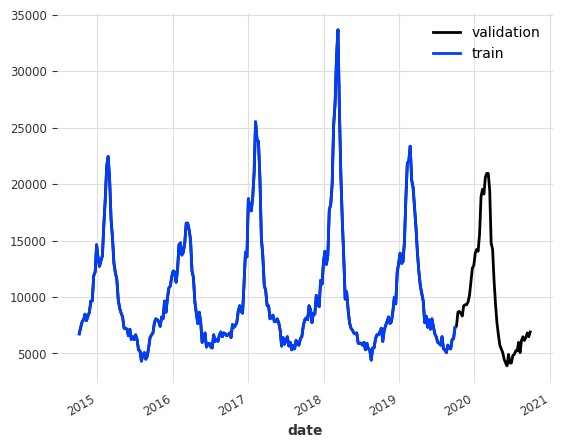

In [9]:
targets_validation[-1]['icosari-sari-DE'].plot(label='validation')
targets_train[-1]['icosari-sari-DE'].plot(label='train')

In [10]:
def objective(config):
    # optimizer = OPTIMIZER_DICT[config.optimizer]
    use_covariates = config.use_covariates
    multiple_series = config.multiple_series
    
    model = LightGBMModel(
        lags=config.lags,
        lags_past_covariates=config.lags_past_covariates if use_covariates else None,
        lags_future_covariates=config.lags_future_covariates,
        num_leaves=config.num_leaves,
        max_depth=config.max_depth,
        learning_rate=config.learning_rate,
        n_estimators=config.n_estimators,
        min_child_samples=config.min_child_samples, 
        subsample=config.subsample, 
        colsample_bytree=config.colsample_bytree,  
        reg_alpha=config.reg_alpha,  # L1 regularization
        reg_lambda=config.reg_lambda,  # L2 regularization
        subsample_freq=config.subsample_freq, 
        min_split_gain=config.min_split_gain,  
        max_bin=config.max_bin,  
        use_static_covariates=config.use_static_covariates,
        verbose=-1,
        likelihood="quantile",
        quantiles=QUANTILES,
        
        **SHARED_ARGS
    )
    
    scores = []
    k=0
    for train, validation, cov in zip(targets_train, targets_validation, covariates):
        k+=1
        
        if multiple_series:
            train = [train[col] for col in train.columns]
            validation = [validation[col] for col in validation.columns]
            cov = [cov]*len(train)
            
        score = compute_validation_score(model, train, validation, cov if use_covariates else None, 
                                         HORIZON, NUM_SAMPLES, METRIC, METRIC_KWARGS, enable_optimization=False) # !!!!!!
        scores.append(score)
        wandb.log({f'WIS_{k}' : score})
    
            
    avg_score = np.mean(scores) # average across all validation periods
    std = np.std(scores)
    var = np.var(scores)
    
    wandb.log({'WIS_std' : std,
               'WIS_var' : var})

    return avg_score

In [11]:
def main():
    run = wandb.init(project="hp-tuning-realtime")
    score = objective(wandb.config)
    wandb.log({"WIS": score})
    run.finish()

In [12]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="hp-tuning-realtime")

Create sweep with ID: rzeikqsv
Sweep URL: https://wandb.ai/dwolffram-karlsruhe-institute-of-technology/hp-tuning-realtime/sweeps/rzeikqsv


In [ ]:
wandb.agent(sweep_id, function=main, count=750)

wandb: Agent Starting Run: bzn5g452 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 4
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 40
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 255
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.1
wandb: 	reg_lambda: 1
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,295.06096
WIS_1,201.12795
WIS_2,371.30996


wandb: Agent Starting Run: jf9m4sxd with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 52
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.7
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,320.82796
WIS_1,224.6198
WIS_2,401.81393


wandb: Agent Starting Run: q8qb6m99 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 16
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 4
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: 25
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.1
wandb: 	reg_lambda: 0.5
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,281.18768
WIS_1,228.80401
WIS_2,283.0209


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5dzfme2i with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 36
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 24
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.5
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,283.78361
WIS_1,213.04647
WIS_2,324.53304


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1tcrn2rm with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 40
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 24
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.7
wandb: 	reg_lambda: 0.5
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,282.75205
WIS_1,224.95514
WIS_2,324.57418


wandb: Agent Starting Run: nzod6p4w with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 24
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 32
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.7
wandb: 	reg_lambda: 1
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,290.51231
WIS_1,236.97917
WIS_2,313.05045


wandb: Agent Starting Run: low49anc with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 44
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 24
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 100
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 1
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,294.83663
WIS_1,218.39372
WIS_2,335.20581


wandb: Agent Starting Run: 90gha0aj with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 52
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 255
wandb: 	max_depth: 25
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.1
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,330.21888
WIS_1,280.09422
WIS_2,380.05455


wandb: Agent Starting Run: vzngfa5y with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 12
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 32
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 500
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.7
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,278.60426
WIS_1,222.6923
WIS_2,314.85741


wandb: Agent Starting Run: ea6vg36d with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 52
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 24
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.7
wandb: 	reg_lambda: 0.7
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,360.02805
WIS_1,285.75091
WIS_2,442.98647


wandb: Agent Starting Run: 5br0r7n1 with config:
wandb: 	colsample_bytree: 0.7
wandb: 	lags: 48
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 20
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0
wandb: 	subsample: 0.7
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,304.1695
WIS_1,227.0457
WIS_2,339.19342


wandb: Agent Starting Run: 3eumublc with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 36
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 32
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: 10
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.7
wandb: 	reg_lambda: 0.7
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,292.28963
WIS_1,236.06427
WIS_2,325.29562


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q012wvm1 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 48
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 36
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 500
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.7
wandb: 	reg_lambda: 1
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,298.20774
WIS_1,220.90484
WIS_2,356.04521


wandb: Agent Starting Run: mpg3op2b with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 24
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 4
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.1
wandb: 	reg_lambda: 0.5
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,284.79271
WIS_1,217.55578
WIS_2,306.27225


wandb: Agent Starting Run: b8ijr6ug with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 24
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 32
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 25
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.1
wandb: 	subsample: 0.7
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,315.00855
WIS_1,274.01902
WIS_2,351.0649


wandb: Agent Starting Run: uq5e03wz with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 12
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 12
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 2048
wandb: 	max_depth: 25
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 75
wandb: 	reg_alpha: 0.1
wandb: 	reg_lambda: 0.1
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,273.33604
WIS_1,226.24859
WIS_2,272.42028


wandb: Agent Starting Run: smcf8lq6 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 20
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 52
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 255
wandb: 	max_depth: 5
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 200
wandb: 	num_leaves: 75
wandb: 	reg_alpha: 0.1
wandb: 	reg_lambda: 0
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,273.44652
WIS_1,213.16695
WIS_2,315.29939


wandb: Agent Starting Run: h9a0ie2d with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 8
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 52
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 2048
wandb: 	max_depth: -1
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.7
wandb: 	reg_lambda: 1
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,279.06767
WIS_1,242.35265
WIS_2,306.9246


wandb: Agent Starting Run: l61vcjq9 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 16
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 16
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 255
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.1
wandb: 	reg_lambda: 1
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,266.00275
WIS_1,222.31492
WIS_2,281.58928


wandb: Agent Starting Run: gwlyvbk1 with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 28
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 1024
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 500
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 1
wandb: 	reg_lambda: 0.7
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,286.94574
WIS_1,241.95899
WIS_2,313.82892


wandb: Agent Starting Run: rtl3zvsj with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 32
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 12
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 255
wandb: 	max_depth: 20
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,289.94609
WIS_1,249.02263
WIS_2,325.39357


wandb: Agent Starting Run: cahr03h0 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 48
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 52
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 2048
wandb: 	max_depth: 15
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,292.39301
WIS_1,205.74887
WIS_2,350.49507


wandb: Agent Starting Run: fvuoyrvg with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 28
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 52
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 25
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 200
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	subsample: 0.7
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,331.07297
WIS_1,260.00397
WIS_2,388.78612


wandb: Agent Starting Run: enh1yw5h with config:
wandb: 	colsample_bytree: 0.7
wandb: 	lags: 32
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 4
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 255
wandb: 	max_depth: -1
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.1
wandb: 	reg_lambda: 1
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,279.83021
WIS_1,223.50912
WIS_2,327.50933


wandb: Agent Starting Run: ev72t3d4 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 36
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 44
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 100
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.1
wandb: 	reg_lambda: 1
wandb: 	subsample: 0.8
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,304.07737
WIS_1,233.13136
WIS_2,368.01499


wandb: Agent Starting Run: 6jao4vw7 with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 20
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 28
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 255
wandb: 	max_depth: 15
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 200
wandb: 	num_leaves: 75
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,277.26896
WIS_1,238.34245
WIS_2,308.92806


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yvffj181 with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 28
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 52
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 1024
wandb: 	max_depth: 25
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.7
wandb: 	reg_lambda: 1
wandb: 	subsample: 0.7
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,282.32021
WIS_1,228.30027
WIS_2,321.24167


wandb: Agent Starting Run: 28uplqdv with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 40
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 40
wandb: 	learning_rate: 0.2
wandb: 	max_bin: 510
wandb: 	max_depth: 5
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0.7
wandb: 	reg_lambda: 0.5
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,299.63203
WIS_1,256.6698
WIS_2,341.22381


wandb: Agent Starting Run: me4u4vfq with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 40
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 8
wandb: 	learning_rate: 0.01
wandb: 	max_bin: 255
wandb: 	max_depth: 20
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 2000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 0.5
wandb: 	subsample: 0.7
wandb: 	subsample_freq: 1
wandb: 	use_covariates: True
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,275.64508
WIS_1,206.59773
WIS_2,316.52688


wandb: Agent Starting Run: xsdtu5vi with config:
wandb: 	colsample_bytree: 1
wandb: 	lags: 32
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 48
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 500
wandb: 	num_leaves: 50
wandb: 	reg_alpha: 0.5
wandb: 	reg_lambda: 1
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_static_covariates: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,311.02273
WIS_1,220.37323
WIS_2,388.73753


wandb: Agent Starting Run: uujtal1o with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 28
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 40
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: 25
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 100
wandb: 	num_leaves: 40
wandb: 	reg_alpha: 0
wandb: 	reg_lambda: 0.7
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 0
wandb: 	use_covariates: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,332.05292
WIS_1,235.39047
WIS_2,408.21226


wandb: Agent Starting Run: okiyu0ko with config:
wandb: 	colsample_bytree: 0.8
wandb: 	lags: 20
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 48
wandb: 	learning_rate: 0.1
wandb: 	max_bin: 255
wandb: 	max_depth: 25
wandb: 	min_child_samples: 10
wandb: 	min_split_gain: 0.2
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 500
wandb: 	num_leaves: 31
wandb: 	reg_alpha: 0.7
wandb: 	reg_lambda: 1
wandb: 	subsample: 0.9
wandb: 	subsample_freq: 5
wandb: 	use_covariates: True
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,324.28313
WIS_1,231.86492
WIS_2,383.349


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0e0s062k with config:
wandb: 	colsample_bytree: 0.9
wandb: 	lags: 16
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 12
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 1024
wandb: 	max_depth: 25
wandb: 	min_child_samples: 20
wandb: 	min_split_gain: 0.1
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 1000
wandb: 	num_leaves: 20
wandb: 	reg_alpha: 0.7
wandb: 	reg_lambda: 0
wandb: 	subsample: 1
wandb: 	subsample_freq: 1
wandb: 	use_covariates: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


WIS,▁
WIS_1,▁
WIS_2,▁
WIS_3,▁
WIS_4,▁
WIS_5,▁
WIS_std,▁
WIS_var,▁
WIS,275.32498
WIS_1,228.82198
WIS_2,305.93392


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vnltbalr with config:
wandb: 	colsample_bytree: 0.7
wandb: 	lags: 44
wandb: 	lags_future_covariates: [0, 4]
wandb: 	lags_past_covariates: 52
wandb: 	learning_rate: 0.05
wandb: 	max_bin: 510
wandb: 	max_depth: 10
wandb: 	min_child_samples: 30
wandb: 	min_split_gain: 0
wandb: 	model: lightgbm
wandb: 	multiple_series: True
wandb: 	n_estimators: 5000
wandb: 	num_leaves: 75
wandb: 	reg_alpha: 0.1
wandb: 	reg_lambda: 0
wandb: 	subsample: 0.7
wandb: 	subsample_freq: 0
wandb: 	use_covariates: False
wandb: 	use_static_covariates: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
